# Diseño del algoritmo precitivo de la longitud del intestino con SVM cuántico



https://quask.readthedocs.io/en/latest/getting_started.html

En este notebook se recoge el codigo relativo al capitulo de diseño del algoritmo predictivo para la longitud del intestino con Support Vector Machines (SVM) Cuántico.

El clasificador diseñado es un `Ensemble` de pequeños clasificadores que se entrenan con un conjunto de datos de entrenamiento parcial. El codigo de cada clasificador se recoge en los notebooks denominados `clfx.ipynb` (siendo x el numero del clasificador).

Cada clasificador genera unas matrices Gram de Kernel que se almacenan como ficheros y se cargan posteriormente en este notebook para entrenar y predecir con los clasificadores elementales. Finalmente el clasificador final se construye como una combinacion ponderada de los clasificadores elementales que permite maximizar la calidad del clasificador final.

El codigo elaborado permite la realización de una serie de figuras que describen las características de los datos utilizados, el proceso de diseño del algoritmo predictivo y la evaluacion de las métricas de prediccion que se obtienen.

El código se ha desarrollado en python 3.10 y adicionalmente se utilizan las librerías de numpy, pandas, matplotLib para la realizacion de calculos, tratamiento de datos y visualizacion. Se utilizan tambien las librerías Scikit-Learn para las operaciones de Aprendizaje Máquina (Machine Learning) relativas al algoritmo SVM. Se utilizan las librerías QuASK para el mecanismo de búsqueda heurística del Kernel óptimo. Adicionalmente se desarrolla un evaluador (`mytraining_cost_evaluator`) que guía con una función de coste el procedimiento de búsqueda.

In [ ]:
#para google_colab
#!pip install -r requirements_colab.txt

In [2]:
import quask
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel

from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import warnings
warnings.filterwarnings('ignore')

El proceso de diseño del algoritmo consta de las siguientes fases:

- Fase de preparacion de los datos: es la fase de carga de los datos y preparacion de los grupos de datos parciales para los clasificadores del `Ensemble`. Se parte de los datos preparados en el capítulo de diseño del modelo clásico donde tenemos las muestras con tres etiquetas de categorias. Esto nos da tres escenarios de prueba, uno para cada tipo de categorizacion.

- Fase de modelizacion de los clasificadores individuales del `Ensemble`: en esta fase cada uno de los notebooks de diseño de los clasificadores individuales se ejecuta en paralelo. En ellos se busca un kernel optimo que genere un clasificador con las mejores métricas para el dataset de entrenamiento. En estos notebooks se parte de un dataset parcial y se busca el kernel optimo. Una vez encontrado, se almacena la matriz de Gram del kernel sobre el data set de test y de entrenamiento como archivos de `numpy` que posteriormente puede leerse desde este notebook para construir todos los clasificadores individuales y el global. 

- Fase de modelizacion y diseño del sistema predictivo: En esta fase se realiza un proceso de `Model Blending` donde se selecciona una conbinacion de clasificadores individuales con diferentes pesos para construir el clasificador global. El clasificador global es un clasificador de voto ponderado donde, cada clasificador elemental realiza una predicción individual para una muestra dada. Luego, se toma una decisión conjunta utilizando un método de votación ponderada, cada clasificador tiene un peso según su rendimiento, y la clase con la suma ponderada más alta es la predicha. Este enfoque ayuda a reducir errores y mejorar la robustez del modelo.

## Fase de Preparacion de los datos

Cargamos el excel generado en el notebook de diseño del modelo predictivo SVM clásico, donde cada una de las muestras tiene establecidas tres categorizaciones diferentes: Categorizacion normal (sobre las etiquetas `labels_step_normal`), Categorización extrema ( sobre las etiquetas `labels_step_tail`) y  Categorización por agrupacion natural de los datos o clustering (sobre las etiquetas `labels_kmeans`)

In [9]:
#Read the train data
total_df = pd.read_excel('data_train_scaled_clustered_steps.xlsx')
print('m num muestras ',total_df.shape[0],' y n num caracteristicas ', total_df.shape[1])
total_df.head()

m num muestras  1090  y n num caracteristicas  17


,Unnamed: 0,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2,EDAD_scaled,PESO_scaled,TALLA_scaled,IMC_scaled,SEXO_1_scaled,SEXO_2_scaled,LONGITUD,labels_kmeans,labels_step_normal,labels_step_tail
0,0,37.0,97.0,172,32.787994,0,1,0.355932,0.202797,0.596154,0.137364,0,1,590,1,1,1
1,1,69.0,122.0,181,37.239401,1,0,0.898305,0.377622,0.769231,0.223505,1,0,860,2,2,2
2,2,55.0,96.0,170,33.217993,1,0,0.661017,0.195804,0.557692,0.145685,1,0,840,2,2,2
3,3,60.0,112.0,165,41.138659,0,1,0.745763,0.307692,0.461538,0.298961,0,1,480,0,0,1
4,4,53.0,82.0,154,34.575814,0,1,0.627119,0.097902,0.250000,0.171961,0,1,460,0,0,0


### Seleccion de variables

Tambien para simplificar el calculo del Kernel cuántico vamos a seleccionar las variables de manera que no cargaremos en nuestro modelo las variables `SEXO_2_scaled` e `IMC_scaled`. Si bien perdemos informacion y simplificamos el modelo, parte de la informacion de estas variables ya esta recogida en otras variables. De esta forma el diseño se realiza sin tener en cuenta estas dos características, ello simplifica el circuito de mapeo de características y eficienta el tiempo de calculo de los Kernels. Esto se justifica dado que la variable `SEXO_2` es 1-`SEXO_1` y la variable `IMC` es el cociente entre el `PESO`y la `TALLA`.

In [ ]:
total_columns=['EDAD_scaled',	'PESO_scaled',	'TALLA_scaled',	'IMC_scaled',	'SEXO_1_scaled',	'SEXO_2_scaled']
#Features to be used in the model
transformed_columns=['EDAD_scaled',	'PESO_scaled',	'TALLA_scaled',	'SEXO_1_scaled']

### Enriquecimiento de los datos (Data Interpolation)

Para conseguir un conjunto de datos de entrenamiento balanceado se utilizan las librerías `smote` que nos permiten contruir conjuntos de datos con clases balanceadas a partir de conjuntos de datos no balanceados.

En el codigo siguiente se crean tres `DataFrames`que contienen datos enriquecidos para las tres categorizaciones que se han definido como escenarios diferentes de entrenamiento.

In [ ]:
#instalacion de las librerías
#!pip install -U imbalanced-learn

In [11]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC

sm = SMOTE(random_state=42)#creamos el estimador con random_state=42
#sm = BorderlineSMOTE(random_state=42)
#sm = SMOTENC(categorical_features=[0, 1],random_state=42)

#Fitting and sampling can also be done in one step with .fit_sample
#data_resampled, targets_resampled = <estimator>.fit_sample(data, targets)
X_res_kmeans, Y_res_kmeans = sm.fit_resample(total_df[transformed_columns].copy(), total_df['labels_kmeans'].copy())
X_res_step_normal, Y_res_step_normal = sm.fit_resample(total_df[transformed_columns].copy(), total_df['labels_step_normal'].copy())
X_res_step_tail, Y_res_step_tail = sm.fit_resample(total_df[transformed_columns].copy(), total_df['labels_step_tail'].copy())

Podemos calcular el numero de muestras en cada clase en las tres DataFrames de entrenamiento, tras el proceso de enriquecimiento.

In [12]:
df_enriched=X_res_kmeans.copy()
df_enriched['labels']=Y_res_kmeans.copy().astype(int)

#df_enriched=X_res_step_normal.copy()
#df_enriched['labels']=Y_res_step_normal.copy().astype(int)

#df_enriched=X_res_step_tail.copy()
#df_enriched['labels']=Y_res_step_tail.copy().astype(int)

display(df_enriched.groupby(['labels'])['labels'].count())
df_enriched.columns

labels
0    499
1    499
2    499
Name: labels, dtype: int64

Index(['EDAD_scaled', 'PESO_scaled', 'TALLA_scaled', 'SEXO_1_scaled',
       'labels'],
      dtype='object')

### Preparacion de los datasets parciales para el entrenamiento de los clasificadores individuales

Hay que tener en cuenta que la simulacion del circuito cuantico va a ser costosa computacionalmente y va a requerir mucho tiempo, un numero elevado de muestras en el conjunto de datos hace que el calculo de la matriz de Gram del Kernel requiera más tiempo. Este tiempo es exponencialmente mas alto con el numero de muestras y hace que la evaluacion de un Kernel tome tiempos elevados para conjuntos de datos de muchas muestras. 

En la literatura [REF] se utiliza un numero reducido de muestras (entre 100 and 200) para realizar el calculo del kernel y el entrenamiento esto hace factible una búsqueda del kernel cuántico en un tiempo razonable. En el caso médico que nos ocupa, ya se ha indicado en el capítulo anterior las dificultades de diseño del algoritmo clásico en base a que la muestra de datos debería de ser de mayor tamaño para poder mejorar las muestras. Esto indica que no es factible el entrenamiento con un número de muestras tan pequeño.

Los resultados obtenidos en el entrenamiento de un modelo con todas las muestras se prueban en este trabajo, pero el calculo de cada Kernel tienen unos tiempos de ejecucion muy elevados y no es posible obtener buenos resultados en las métricas de clasificacion. Ante esta limitación se opta por tomar la estrategia de entrenar un conjunto de clasificadores más pequeños, de modo que cada uno de ellos se entrena sobre un conjunto de datos pequeño.

En este paso de la fase de preparacion de datos, se parte el conjunto de datos de entrenamiento en grupos para los clasificadores individuales. En concreto se prueban dos particiones:

- 4 grupos: dividir los datos originales en 4 partes de igual tamaño, utilizando 3 grupos para entrenar tres clasificadores individuales y un ultimo grupo para test, como datos sobre los que validaremos el clasificador global

- 8 grupos: dividir los datos originales en 8 partes de igual tamaño, utilizando 7 grupos para entrenar tres clasificadores individuales y un ultimo grupo para test, como datos sobre los que validaremos el clasificador global

Comentamos aqui que a un clasificador individual toma los siguientes tiempos para el calculo de una matrices de Gram en funcion de las muestras que considere para el calculo:

- ~200 muestras, en torno a 30min
- ~750 muestras, unas 4h

Por ello se considera finalmente la particion de 8 grupos como la más favorable, dado que aunque requiere de más clasificadores individuales, tiene unos tiempos de calculo de cada matriz de 30min.


### 4GRUPOS

Se dividen los datos de entrada en 4 grupos con distribucion uniformeme de clases en cada uno de ellos, utilizando el modulo `train_test_split` de `scikit-learn`

In [33]:
from sklearn.model_selection import train_test_split
Xinicial_a, Xinicial_b, yinicial_a, yinicial_b = train_test_split(X_res_kmeans, Y_res_kmeans, train_size=0.5, random_state=42)
X1, X2, y1, y2 = train_test_split(Xinicial_a, yinicial_a, train_size=0.5, random_state=42)
X3, X4, y3, y4 = train_test_split(Xinicial_b, yinicial_b, train_size=0.5, random_state=42)

#todos
Xs= [X1,X2,X3,X4]
ys= [y1,y2,y3,y4]

for X,y in zip(Xs,ys):
    print('m num muestras ',X.shape,' y n num labels ', y.shape)

#train y test
Xs_train=[X1,X2,X3]
Xs_test= [X4]
ys_train= [y1,y2,y3]
ys_test= [y4]


m num muestras  (374, 4)  y n num labels  (374,)
m num muestras  (374, 4)  y n num labels  (374,)
m num muestras  (374, 4)  y n num labels  (374,)
m num muestras  (375, 4)  y n num labels  (375,)


Se almacenan en diferentes directorios, para que pueda hacer uso de ellos cada clasificador individual

In [13]:
# Guardar los matrices en archivos excel
grupo1= X1.copy()
grupo1['labels']=y1
grupo1.to_excel('datos/4groups/grupo1.xlsx')

grupo2= X2.copy()
grupo2['labels']=y2
grupo2.to_excel('datos/4groups/grupo2.xlsx')

grupo3= X3.copy()
grupo3['labels']=y3
grupo3.to_excel('datos/4groups/grupo3.xlsx')

grupo4= X4.copy()
grupo4['labels']=y4
grupo4.to_excel('datos/4groups/grupo4.xlsx')


### 8 GRUPOS

Se dividen los datos de entrada en 8 grupos con distribucion uniformeme de clases en cada uno de ellos, utilizando el modulo `train_test_split` de `scikit-learn`

In [14]:
from sklearn.model_selection import train_test_split
Xinicial_a, Xinicial_b, yinicial_a, yinicial_b = train_test_split(X_res_kmeans, Y_res_kmeans, train_size=0.5, random_state=42)
X1a, X2a, y1a, y2a = train_test_split(Xinicial_a, yinicial_a, train_size=0.5, random_state=42)
X3b, X4b, y3b, y4b = train_test_split(Xinicial_b, yinicial_b, train_size=0.5, random_state=42)

X1, X2, y1, y2 = train_test_split(X1a, y1a, train_size=0.5, random_state=42)
X3, X4, y3, y4 = train_test_split(X2a, y2a, train_size=0.5, random_state=42)
X5, X6, y5, y6 = train_test_split(X3b, y3b, train_size=0.5, random_state=42)
X7, X8, y7, y8 = train_test_split(X4b, y4b, train_size=0.5, random_state=42)

#todos
Xs= [X1,X2,X3,X4,X5,X6,X7,X8]
ys= [y1,y2,y3,y4,y5,y6,y7,y8]

for X,y in zip(Xs,ys):
    print('m num muestras ',X.shape,' y n num labels ', y.shape)

#train y test
Xs_train=[X1,X2,X3,X4,X5,X6,X7]
Xs_test= [X8]
ys_train= [y1,y2,y3,y4,y5,y6,y7]
ys_test= [y8]

m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (187, 4)  y n num labels  (187,)
m num muestras  (188, 4)  y n num labels  (188,)


Se almacenan en diferentes directorios, para que pueda hacer uso de ellos cada clasificador individual

In [15]:
# Guardar los matrices en archivos excel
groups='8groups'

grupo1= X1.copy()
grupo1['labels']=y1
grupo1.to_excel(f'datos/{groups}/grupo1.xlsx')

grupo2= X2.copy()
grupo2['labels']=y2
grupo2.to_excel(f'datos/{groups}/grupo2.xlsx')

grupo3= X3.copy()
grupo3['labels']=y3
grupo3.to_excel(f'datos/{groups}/grupo3.xlsx')

grupo4= X4.copy()
grupo4['labels']=y4
grupo4.to_excel(f'datos/{groups}/grupo4.xlsx')

grupo5= X5.copy()
grupo5['labels']=y5
grupo5.to_excel(f'datos/{groups}/grupo5.xlsx')

grupo6= X6.copy()
grupo6['labels']=y6
grupo6.to_excel(f'datos/{groups}/grupo6.xlsx')

grupo7= X7.copy()
grupo7['labels']=y7
grupo7.to_excel(f'datos/{groups}/grupo7.xlsx')

grupo8= X8.copy()
grupo8['labels']=y8
grupo8.to_excel(f'datos/{groups}/grupo8.xlsx')

## Fase de modelizacion de los clasificadores individuales

En esta fase se ejecutan en paralelo cada uno de los notebooks de los clasificadores individuales. El numero de clasificadores puede ser 3 u 7 y en cada uno de ellos se diseña un SVM cuántico que ve solamente un grupo parcial de muestras de datos de entrada.

En el caso en el que se partan los datos en 8 grupos, tendremos grupos de datos de unas 200 muestras aproximadamente y 7 clasificadores individuales. Cada clasificador toma ese subconjunto de muestras e intentará encontrar un circuito cuántico que construya un Kernel optimo para nuestro algortimo predictivo.

Una vez encontrado, se almacena la matriz de Gram del kernel sobre el data set de test (K_test) y de entrenamiento (K_train) como archivos de `numpy` que posteriormente puede leerse desde este notebook para construir todos los clasificadores individuales y el global. 

El Kernel optimo recoge la información de las operaciones que contiene el circuito cuántico y estos datos dan nombre al fichero de las matrices de Gram del kernel. Tambien en el notebook de optimización se calcula la constante de regularizacion `C` que da mejores resultados sobre el conjunto de datos de entrenamiento. Estos datos se utilizan para caontruir el clasificador optimo individual y cargarlo en este notebook, para construir el clasificador global.

## Fase de modelizacion y diseño del sistema predictivo

En esta fase se realiza un proceso de `Model Blending` donde se selecciona una conbinacion de clasificadores individuales con diferentes pesos para construir el clasificador global. 

Primeramente se cargan los clasificadores optimos individuales, se entrenan sobre los datos de entrenamiento y se calculan las predicciones de cada uno de ello para el dataset de test

In [39]:
num_grupos=8
groups=str(num_grupos)+'groups'
idx=list(range(num_grupos-1))

# file_operations=['o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XZ_21_2_0.69-o3_XZ_03_3_0.91', 
#                  'o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9',
#                  'o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9']
#optimal_cs=[1,70,8]
file_operations=['o0_ZX_13_0_0.89-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9']+['o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9']*5+['o0_XX_01_0_0.9-o1_YI_01_1_0.49-o2_XX_23_2_0.9-o3_XX_30_3_0.9']*2

optimal_cs=[30,80,50,100,90,100,60]
classifiers=[SVC(kernel='precomputed',C=c) for c in optimal_cs]
ys_pred=[]

for i in idx:
    X,y = Xs_train[i],ys_train[i]
    clf=classifiers[i]
    print(f'classifier clf{i}- num muestras {X.shape} training')
    

    # Calculate the kernel Gram matrices
    # same kernel with different data for each classifier
    #start = time.time()
    #K_train = kernel.build_kernel(X, X)
    K_train= np.load(f'kernels/kernel_medico/{groups}/grupo{str(i+1)}/K_train_{str(file_operations[i])}.npy')
    clf.fit(K_train, y)
    #end = time.time()
    #print('train - time elapsed', (end-start)/60 ,'min')

    # Predict the labels for the test data
    #start = time.time()
    #K_test = kernel.build_kernel(Xs_test, Xs_train[i])
    K_test = np.load(f'kernels/kernel_medico/{groups}/grupo{str(i+1)}/K_test_{str(file_operations[i])}.npy')
    ys_pred.append(clf.predict(K_test))
    #end = time.time()
    #print('prediction - time elapsed', (end-start)/60 ,'min')

#ys_pred

classifier clf0- num muestras (187, 4) training
classifier clf1- num muestras (187, 4) training
classifier clf2- num muestras (187, 4) training
classifier clf3- num muestras (187, 4) training
classifier clf4- num muestras (187, 4) training
classifier clf5- num muestras (187, 4) training
classifier clf6- num muestras (187, 4) training


El clasificador global es un clasificador de voto ponderado donde, cada clasificador elemental realiza una predicción individual para una muestra dada. Luego, se toma una decisión conjunta utilizando un método de votación ponderada, cada clasificador tiene un peso según su rendimiento, y la clase con la suma ponderada más alta es la predicha. Este enfoque ayuda a reducir errores y mejorar la robustez del modelo.

Para realizar la prediccion se crea un sistema de votacion ponderado se crea un vector de pesos para cada clasificador individual y un vector de prediccion final tomando las predicciones de cada clasificador que estan ponderadas por el peso que le damos y decidiendo que la clase con más votos es la prediccion final. Tambien se toma en consideracion el caso en el que pueda haber un empate de votos entre varias clases, caso en el cual se hace un desempate aleatorio que decide la prediccion final

Total Accuracy (for all classes): 0.5159574468085106
              precision    recall  f1-score   support

           0       0.53      0.66      0.59        70
           1       0.42      0.23      0.30        60
           2       0.54      0.64      0.58        58

    accuracy                           0.52       188
   macro avg       0.50      0.51      0.49       188
weighted avg       0.50      0.52      0.50       188



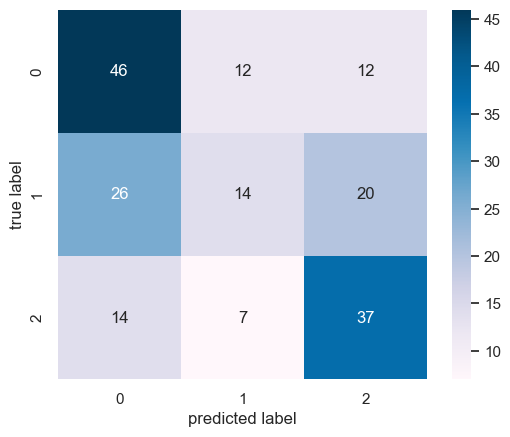

In [41]:
import numpy as np
from scipy.stats import mode

# Example arrays of predictions
# y_pred1 = np.array([0, 1, 2, 2, 0])
# y_pred2 = np.array([0, 1, 0, 1, 2])
# y_pred3 = np.array([1, 1, 2, 0, 1])

# Stack the prediction arrays together
#predictions = np.vstack((ys_pred[0], ys_pred[1], ys_pred[2]))
predictions = np.vstack((ys_pred[0], ys_pred[1], ys_pred[2],ys_pred[3],ys_pred[4], ys_pred[5], ys_pred[6]))

# Define weights for each prediction array
#weights = np.array([0.5, 1, 0.5])  # Weights for y_pred1, y_pred2, y_pred3 [0 1 2 1 1]
weights = np.array([1, 1, 2, 2, 2, 1, 1])  # Weights for y_pred1, y_pred2, y_pred3 [0 1 2 0 0]

# Initialize array to store weighted votes
weighted_votes = np.zeros((predictions.shape[1], 3))  # 3 classes: 0, 1, 2

# Apply weights to the votes
for i, pred in enumerate(predictions):
    for j in range(3):  # For each class (0, 1, 2)
        weighted_votes[:, j] += (pred == j) * weights[i]

# Initialize array to store final predictions
final_predictions = np.zeros(predictions.shape[1], dtype=int)

# Determine the final predictions with tie-breaking
for i in range(weighted_votes.shape[0]):
    max_vote = np.max(weighted_votes[i])
    candidates = np.where(weighted_votes[i] == max_vote)[0]  # Classes with the maximum vote
    if len(candidates) > 1:  # Tie
        final_predictions[i] = np.random.choice(candidates)  # Randomly choose one of the tied classes
    else:
        final_predictions[i] = candidates[0]  # No tie, take the class with the max vote


# Get the final predictions based on the maximum weighted vote
# final_predictions = np.argmax(weighted_votes, axis=1)
# print("y_pred1:", ys_pred[0][:20])
# print("y_pred2:", ys_pred[1][:20])
# print("y_pred3:",  ys_pred[2][:20])
# print("y_pred4:", ys_pred[3][:20])
# print("y_pred5:", ys_pred[4][:20])
# print("y_pred6:",  ys_pred[5][:20])
# print("y_pred7:", ys_pred[6][:20])
# print('--------------------------------------------------------')
# print("Final  :", final_predictions[:20])
# print('Weighted_Votes', weighted_votes[:20])

###METRICAS CLASIFICACION#######################
# Calculate the accuracy
y_test_pred= final_predictions
accuracy = np.sum(ys_test[0] == y_test_pred) / len(ys_test[0])
print("Total Accuracy (for all classes):", accuracy)

#confussion matrix metrics
print(metrics.classification_report(ys_test[0],y_test_pred))

#confusion matrix plot
sn.set()
mat = confusion_matrix(ys_test[0],y_test_pred)
sn.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('predicted label')
plt.ylabel('true label');


### Ajuste fino de pesos del clasificador global

Para poder haber decidido la combinacion de pesos de ponderacion de los clasificadores individuales, se realiza previamente una busqueda combinatoria del vector de pesos que nos de unas metricas de prediccion globales optima sobre los datos de entrenamiento.

In [ ]:
predictions = np.vstack((ys_pred[0], ys_pred[1], ys_pred[2],ys_pred[3],ys_pred[4], ys_pred[5], ys_pred[6]))
weights = np.array([1, 1, 1, 1, 1, 1, 1])  # Weights for y_pred1, y_pred2, y_pred3 [0 1 2 0 0]
total_f1=0
for s in range(0,100):
    np.random.seed(s)
    print(s)
    for w1 in range(3): #range(10):
        for w2 in range(3): #range(10):  
            for w3 in range(3): #range(10):
                for w4 in range(3): #range(10):
                    for w5 in range(10):
                        for w6 in range(3): #range(10):
                            for w7 in range(10): 
                                weights = np.array([w1, w2, w3, w4, w5, w6, w7])  # Weights for y_pred1, y_pred2, y_pred3 [0 1 2 0 0]
                                weighted_votes = np.zeros((predictions.shape[1], 3))  # 3 classes: 0, 1, 2
                                for i, pred in enumerate(predictions):
                                    for j in range(3):  # For each class (0, 1, 2)
                                        weighted_votes[:, j] += (pred == j) * weights[i]
                                final_predictions = np.zeros(predictions.shape[1], dtype=int)
                                for i in range(weighted_votes.shape[0]):
                                    max_vote = np.max(weighted_votes[i])
                                    candidates = np.where(weighted_votes[i] == max_vote)[0]  # Classes with the maximum vote
                                    if len(candidates) > 1:  # Tie
                                        final_predictions[i] = np.random.choice(candidates)  # Randomly choose one of the tied classes
                                    else:
                                        final_predictions[i] = candidates[0]  # No tie, take the class with the max vote
                                y_test_pred= final_predictions
                                m=metrics.classification_report(ys_test[0],y_test_pred)
                                f1_c0=100*float(m.split('\n')[2].split('      ')[4]) #f1-score accuracy class 0
                                f1_c1=100*float(m.split('\n')[3].split('      ')[4]) #f1-score accuracy class 1
                                f1_c2=100*float(m.split('\n')[4].split('      ')[4]) #f1-score accuracy class 2
                                f1_all=100*float(m.split('\n')[6].split('      ')[4]) #f1-score accuracy all classes
                                not_cero= (f1_c0 !=0) and (f1_c1 !=0) and (f1_c2 !=0)
                                if total_f1<f1_c0+f1_c1+f1_c2 and not_cero:
                                    total_f1=f1_c0+f1_c1+f1_c2
                                    print(s,'---',w1,w2,w3,w4,w5,w6,w7,'----------------------------------')
                                    print(' f1-score accuracy '+str(f1_c0+f1_c2)+ ' all '+str(f1_c0+f1_c1+f1_c2),'--------------------------')
                                    print(m)
sn.set()
mat = confusion_matrix(ys_test[0],y_test_pred)
sn.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('predicted label')
plt.ylabel('true label');

Definimos el modelo de Machine Learning, algoritmo Support Vector Machines Classifier [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) con un kernel, por lo que especificamos la opcion `precomputed` que indica que pasaremos al algoritmo la kernel `matriz de Gram` en lugar de los datos originales

In [8]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

Calculamos nuestra `matriz de Gram` con un kernel cuantico definido en este caso para datos con 4 características, con un circuito de 6 qubits y aplicando 6 operaciones que son en realidad la misma operacion aplicada a 4 parejas de qubits y que consisten en un operador con $\beta=0.9$ y los operadores $\sigma_x$ y $\sigma_x$

Para hacer un seguimiento y grabar las matrices Gram que calculamos con cada kernel creamos un string que define las operaciones del `Ansatz` y que dara nombre al fichero donde cuardemos la matriz

Cada operacion se describe como una tupla: (α, β, p, q, k, j) 

- α, β ∈ {0, 1, 2, 3} indica una de las matrices de Pauli
- los qubits de la operacion p ∈ {0, ..., n − 1} para el primero sobre el que actua la transformacion, q ∈ {0, ..., n − 2} para el segundo, que debe de ser distinto del primero
- la caracteristica de los datos que utilizamos como parametro para la transformacion k ∈ {0, ..., n − 1}
- j ∈ {0, ..., b − 1} el valor de escalado (bandwidth, ancho de banda).

la cadena que caracteriza la operacion será: # oindex_α_β_p_q_k_j

In [20]:
def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, n_shots=None)

#La siguiente instruccion solo se puede ejecutar una vez en el entorno, si da error comentar que ya esta ejecutada y cargada en memoria
KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')

In [9]:
# Number of features in the data point to be mapped in the Hilbert space of the quantum system
N_FEATURES = 4

# Number of gates applied to the quantum circuit
N_OPERATIONS = 4

# Number of qubits of the quantum circuit
N_QUBITS = 4

# Ansatz object, representing the feature map
# Each operation is described by a tuple: (α, β, p, q, k, j) 
# operation_index_αβ_pq_k_j
operations=''
ansatz = Ansatz(n_features=4, n_qubits=4, n_operations=4)
ansatz.initialize_to_identity()
i,a,b,p,q,k,j=0,'X','X',0,1,0,0.9
operations += 'o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)+'-'
ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
i,a,b,p,q,k,j=1,'X','X',1,2,1,0.9
operations += 'o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)+'-'
ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
i,a,b,p,q,k,j=2,'X','X',2,3,2,0.9
operations += 'o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)+'-'
ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
i,a,b,p,q,k,j=3,'X','X',3,0,3,0.9
operations += 'o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)
ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
print('string operations',operations)

string operations o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9


In [10]:
def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, n_shots=None)

#La siguiente instruccion solo se puede ejecutar una vez en el entorno, si da error comentar que ya esta ejecutada y cargada en memoria
KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')

n_features 4
n_qubits 4
n_operations 4
operation_list [-i 0.90 * x[0] XX^(0,1), -i 0.90 * x[1] XX^(1,2), -i 0.90 * x[2] XX^(2,3), -i 0.90 * x[3] XX^(3,0)]


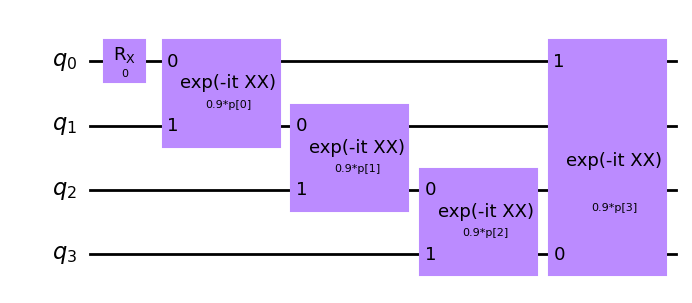

In [12]:
# create Quantum Kernel
kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)
# recordamos como es nuestro circuito
print('n_features', ansatz.n_features)
print('n_qubits', ansatz.n_qubits)
print('n_operations', ansatz.n_operations)
print('operation_list', ansatz.operation_list)

circuit=kernel.get_qiskit_ansatz()
circuit.draw(output="mpl", fold=-1)

In [13]:
# Calculate the kernel Gram matrices
# Fit the model to the training data
start = time.time()
K_train = kernel.build_kernel(X_train, X_train)
model.fit(K_train, y_train)
end = time.time()

print('train - time elapsed', (end-start)/60 ,'min')

train - time elapsed 199.0592569430669 min


Una vez entrenado el modelo con las muestras de entrenamiento, realizamos la prediccion sobre el conjunto de datos de test y mediremos la calidad de la prediccion con las metricas de clasificacion de la matriz de confusion [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) sobre el conjunto de datos de test

Hay que tener en cuenta que la simulacion del circuito cuantico va a ser costosa computacionalmente y va a requerir mucho tiempo, por lo que reducimos el numero de muestras en el set de test para la evaluacion tambien 

Dividimos el conjunto de datos en datos de test inicial (20%) y datos de test restantes (80%).

20% con clases de kmeans son 300 muestras

In [ ]:
#NO TENEMOS SET DE EVALUACION, SOLO TRAIN Y TEST
#evaluate only for 25% of the test data set
# X_test_25, X_test_75, y_test_25, y_test_75 = train_test_split(X_test, y_test, train_size=0.25, random_state=42)

# X_test=X_test_25.copy()
# y_test=y_test_25.copy()

# print('m num muestras ',X_test.shape[0],' y n num caracteristicas ', X_test.shape[1])

prediction - time elapsed 222.9219367702802 min
Total Accuracy (for all classes): 0.48731642189586116
              precision    recall  f1-score   support

           0       0.48      0.76      0.59       246
           1       0.00      0.00      0.00       258
           2       0.50      0.72      0.59       245

    accuracy                           0.49       749
   macro avg       0.33      0.50      0.39       749
weighted avg       0.32      0.49      0.39       749



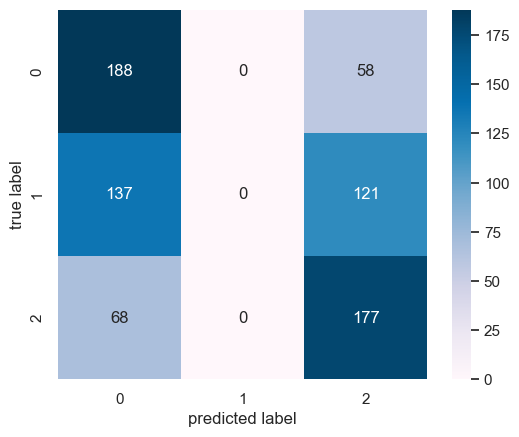

In [14]:
###METRICAS CLASIFICACION#######################
# Predict the labels for the test data
start = time.time()
K_test = kernel.build_kernel(X_test, X_train)
y_test_pred = model.predict(K_test)
end = time.time()
print('prediction - time elapsed', (end-start)/60 ,'min')

# Calculate the accuracy
accuracy = np.sum(y_test == y_test_pred) / len(y_test)
print("Total Accuracy (for all classes):", accuracy)

#confussion matrix metrics
print(metrics.classification_report(y_test,y_test_pred))

#confusion matrix plot
sn.set()
mat = confusion_matrix(y_test,y_test_pred)
sn.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('predicted label')
plt.ylabel('true label');

Podemos guardar las `matrices de Gram` en un fichero para no tener que volver a calcularlas:

In [18]:
# Guardar las matrices en archivos .npy
np.save('kernels/kernel_medico/m750/K_train_'+operations+'.npy', K_train)
np.save('kernels/kernel_medico/m750/K_test_'+operations+'.npy', K_test)

Y simplemente importarlas cuando sea conveniente:

In [19]:
# Cargar las matrices desde los archivos .npy
K_train_cargada = np.load('kernels/kernel_medico/m750/K_train_'+operations+'.npy')
K_test_cargada = np.load('kernels/kernel_medico/m750/K_test_'+operations+'.npy')

Podemos visualizar el Kernel calculado con nuestro circuito cuantico para este conjunto de datos:

Training Gram matrix [[1.         0.9789559  0.97241531 ... 0.34938788 0.33716069 0.35962084]
 [0.9789559  1.         0.93152721 ... 0.35313523 0.33012922 0.36110273]
 [0.97241531 0.93152721 1.         ... 0.36325758 0.35570394 0.35665415]
 ...
 [0.34938788 0.35313523 0.36325758 ... 1.         0.96240667 0.96468547]
 [0.33716069 0.33012922 0.35570394 ... 0.96240667 1.         0.97739386]
 [0.35962084 0.36110273 0.35665415 ... 0.96468547 0.97739386 1.        ]]
Testing Gram matrix  [[0.32365794 0.3110699  0.35186561 ... 0.93865236 0.99190273 0.94514247]
 [0.33282475 0.32645851 0.35305397 ... 0.9643109  0.9996046  0.97429279]
 [0.37226786 0.38482931 0.35290576 ... 0.92626467 0.85739711 0.92791609]
 ...
 [0.30074331 0.28218811 0.32121234 ... 0.80793012 0.93192084 0.89221101]
 [0.93758496 0.98777055 0.8735659  ... 0.34126715 0.30712102 0.3458014 ]
 [0.36348082 0.35825726 0.36156882 ... 0.94151533 0.97732231 0.99327429]]


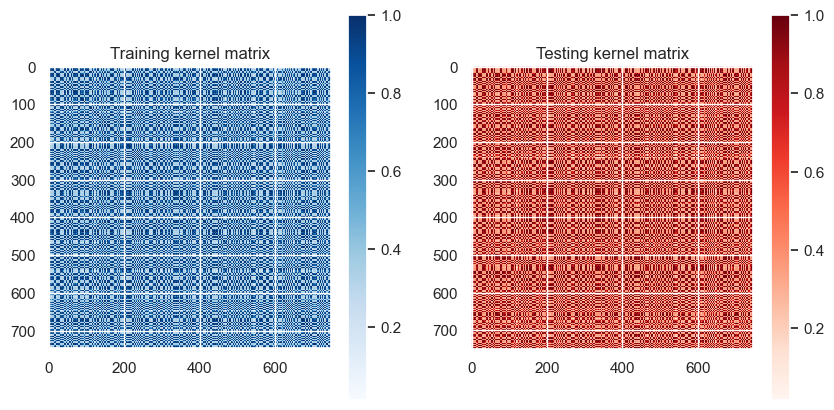

In [20]:
#Las matrices de Gram para los conjuntos de datos de train y test
#K_train=K_train_cargada
#K_test=K_test_cargada
print('Training Gram matrix', K_train)
print('Testing Gram matrix ', K_test)

#visualizacion como imagenes de los valores de las matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im=axs[0].imshow(
    np.asmatrix(K_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
fig.colorbar(im)

im=axs[1].imshow(np.asmatrix(K_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

fig.colorbar(im)
plt.show()

#### Ajuste fino

Podemos hacer un ajuste del parametro de regularizacion C

In [21]:
cs = [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
#Setting C: C is 1 by default and it’s a reasonable default choice. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.
#Meanwhile, larger C values will take more time to train

X_eval= X_test.copy()
y_eval= y_test.copy()

maxmean = 0
for c in cs:
    # Instantiate a machine learning model
    model = SVC(kernel='precomputed', C=c)
    model.fit(K_train, y_train)
    y_test_pred = model.predict(K_test)
    #confussion matrix metrics
    m=metrics.classification_report(y_eval,y_test_pred)
    f1_c0=100*float(m.split('\n')[2].split('      ')[4]) #f1-score accuracy class 0
    f1_c1=100*float(m.split('\n')[3].split('      ')[4]) #f1-score accuracy class 1
    f1_c2=100*float(m.split('\n')[4].split('      ')[4]) #f1-score accuracy class 2
    f1_all=100*float(m.split('\n')[6].split('      ')[4]) #f1-score accuracy all classes
    not_cero= (f1_c0 !=0) and (f1_c1 !=0) and (f1_c2 !=0)

    print('kernel '+operations+'-c '+str(c)+'--------------------------')
    if maxmean<f1_c2 and not_cero:   
        maxmean=f1_c2
        #print('kernel '+str(kernel)+'-gamma '+str(gamma)+'-c '+str(c)+'--------------------------')
        print('f1-score accuracy '+str(maxmean)+'--------------------------')
        print(m)


kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 0.001--------------------------
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 0.01--------------------------
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 0.1--------------------------
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 1--------------------------
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 2--------------------------
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 3--------------------------
f1-score accuracy 59.0--------------------------
              precision    recall  f1-score   support

           0       0.48      0.76      0.59       246
           1       0.50      0.00      0.01       258
           2       0.50      0.72      0.59       245

    accuracy                           0.49       749
   macro avg       0.49      0.50      0.40       749
weighted avg       0.49      0.49 

#### RESULTADOS

##### m300 -train - time elapsed 36.25854622125625 min

INICIAL
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-C=1
prediction - time elapsed 39.98384000062943 min
Total Accuracy (for all classes): 0.4816053511705686
              precision    recall  f1-score   support

           0       0.47      0.75      0.58        89
           1       0.00      0.00      0.00       112
           2       0.50      0.79      0.61        98

    accuracy                           0.48       299
   macro avg       0.32      0.51      0.39       299
weighted avg       0.30      0.48      0.37       299

FINETUNNING C
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 9
f1-score accuracy 63.0--------------------------
              precision    recall  f1-score   support

           0       0.48      0.74      0.58        89
           1       0.60      0.03      0.05       112
           2       0.51      0.82      0.63        98

    accuracy                           0.50       299
   macro avg       0.53      0.53      0.42       299
weighted avg       0.54      0.50      0.40       299

1- Evaluating the `Ansatz`

Cost (norm of A): 0.13943
Calculation time 3.9249404788017275 min

Cost (-1 * rank of DLA): -8.00000
Calculation time 0.0 min

Cost (number of gates): 16.00000
Calculation time 0.0 min

2- Evaluating `Ansatz` and training data

3- Evaluating `Ansatz` training data and labels

The cost according to the KTA is: -0.5868063518210512
Calculation time 0.0001126249631245931 min

The cost according to the Centered-KTA is: -0.043130766532592346
Calculation time 1.89820925394694e-05 min

The cost according to the Ridge Generalization is: 0.06305646845806023
Calculation time 11.671436599890392 min

The cost according to the S-model complexity is: 1808.1285633289895
Calculation time 3.580252329508463e-05 min

The cost according to SpectralBiasEvaluator is: 0.9630912409550496
Calculation time 0.0005549073219299316 min

##### m750

train train - time elapsed 199.0592569430669 min
prediction - time elapsed 222.9219367702802 min
Total Accuracy (for all classes): 0.48731642189586116
              precision    recall  f1-score   support

           0       0.48      0.76      0.59       246
           1       0.00      0.00      0.00       258
           2       0.50      0.72      0.59       245

    accuracy                           0.49       749
   macro avg       0.33      0.50      0.39       749
weighted avg       0.32      0.49      0.39       749

FINE TUNNING
kernel o0_XX_01_0_0.9-o1_XX_12_1_0.9-o2_XX_23_2_0.9-o3_XX_30_3_0.9-c 30--------------------------
f1-score accuracy 61.0--------------------------
              precision    recall  f1-score   support

           0       0.48      0.74      0.58       246
           1       0.36      0.05      0.09       258
           2       0.53      0.71      0.61       245

    accuracy                           0.49       749
   macro avg       0.46      0.50      0.43       749
weighted avg       0.45      0.49      0.42       749

1- Evaluating the `Ansatz`
Cost (norm of A): 0.13787
Calculation time 4.2097963213920595 min
Cost (-1 * rank of DLA): -8.00000
Calculation time 0.0 min
Cost (number of gates): 16.00000
Calculation time 0.0 min
2- Evaluating `Ansatz` and training data
3- Evaluating `Ansatz` training data and labels
The cost according to the KTA is: -0.5687334591596912
Calculation time 9.994109471638997e-05 min
The cost according to the Centered-KTA is: -0.06384037140477339
Calculation time 0.0003351171811421712 min
The cost according to the Ridge Generalization is: 0.03964900218440041
Calculation time 87.83001732428869 min
The cost according to the S-model complexity is: 1657.2181877415594
Calculation time 0.0004459659258524577 min
The cost according to SpectralBiasEvaluator is: 0.981225314635943
Calculation time 0.007366542021433512 min




## Criterios para evaluar un Kernel cuántico

Evaluamos todos los criterios de calidad de los Kernels creados

In [22]:
from quask.evaluator import HaarEvaluator, LieRankEvaluator, CoveringNumberEvaluator
from quask.evaluator import GeometricDifferenceEvaluator
from quask.evaluator import CenteredKernelAlignmentEvaluator, KernelAlignmentEvaluator, RidgeGeneralizationEvaluator, EssModelComplexityEvaluator, SpectralBiasEvaluator

print('1- Evaluating the `Ansatz`')
#the lower the better
start = time.time()
he = HaarEvaluator(n_bins=40, n_samples=10000)
cost = he.evaluate(kernel=kernel, K=None, X=None, y=None)
print(f"Cost (norm of A): {cost:3.5f}")
end = time.time()
print('Calculation time',(end-start)/60 ,'min')
#Cost (norm of A): 0.13593
#Calculation time 6.8179036776224775 min

start = time.time()
lre = LieRankEvaluator(T=500)
cost = lre.evaluate(kernel=kernel, K=None, X=None, y=None)
print(f"Cost (-1 * rank of DLA): {cost:3.5f}")
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

# #return 2** len(trainable_operations)
start = time.time()
cn_eval = CoveringNumberEvaluator()
cost = cn_eval.evaluate(kernel=kernel, K=None, X=None, y=None)
print(f"Cost (number of gates): {cost:3.5f}")
end = time.time()
print('Calculation time',(end-start)/60 ,'min')


print('2- Evaluating `Ansatz` and training data')
#GeometricDifferenceEvaluator needs a list of classic kernels


print('3- Evaluating `Ansatz` training data and labels')
#one can input kernel and X or K_train-scaled instead
#some requiere both -inneficient check source code
start = time.time()
ka = KernelAlignmentEvaluator()
cost = ka.evaluate(kernel=None, K=K_train, X=None, y=y_train)
print("The cost according to the KTA is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
ce = CenteredKernelAlignmentEvaluator()
cost = ce.evaluate(kernel=None, K=K_train, X=None, y=y_train)
print("The cost according to the Centered-KTA is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
ridge_eval = RidgeGeneralizationEvaluator()
cost = ridge_eval.evaluate(kernel=kernel, K=K_train, X=X_train, y=y_train)
print("The cost according to the Ridge Generalization is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
smc_eval = EssModelComplexityEvaluator()
cost = smc_eval.evaluate(kernel=None, K=K_train, X=None, y=y_train)
print("The cost according to the S-model complexity is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

start = time.time()
sb_eval = SpectralBiasEvaluator(10)
cost = sb_eval.evaluate(kernel=kernel, K=K_train, X=X_train, y=y_train)
print("The cost according to SpectralBiasEvaluator is:", cost)
end = time.time()
print('Calculation time',(end-start)/60 ,'min')

1- Evaluating the `Ansatz`
Cost (norm of A): 0.13787
Calculation time 4.2097963213920595 min
Cost (-1 * rank of DLA): -8.00000
Calculation time 0.0 min
Cost (number of gates): 16.00000
Calculation time 0.0 min
2- Evaluating `Ansatz` and training data
3- Evaluating `Ansatz` training data and labels
The cost according to the KTA is: -0.5687334591596912
Calculation time 9.994109471638997e-05 min
The cost according to the Centered-KTA is: -0.06384037140477339
Calculation time 0.0003351171811421712 min
The cost according to the Ridge Generalization is: 0.03964900218440041
Calculation time 87.83001732428869 min
The cost according to the S-model complexity is: 1657.2181877415594
Calculation time 0.0004459659258524577 min
The cost according to SpectralBiasEvaluator is: 0.981225314635943
Calculation time 0.007366542021433512 min


## Optimization of quantum kernels

El paquete `quask.optimizer` permite definir un procedimiento de optimización para Kernels cuánticos. La interfaz principal es la clase `BaseKernelOptimizer`, que requiere:

* una función del Kernel, que servirá como punto inicial de la rutina de optimización;
* un evaluador del Kernel, que será la función de costes que guiará la optimización;
* posiblemente algunos datos de entrada, si los necesita el evaluador del Kernel.

Devuelve una nueva instancia de `quask.core.Kernel` para ser utilizada

In [ ]:
import copy
from quask.optimizer.base_kernel_optimizer import BaseKernelOptimizer
from quask.evaluator import CenteredKernelAlignmentEvaluator

def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, n_shots=None)

#KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')


In [ ]:
!pip install mushroom-rl

### Random Search

In [ ]:
#PRUEBA CREAR CIRCUITOS RANDOM
# ponemos num operacion= num feature para tenerlas siempre todas
# empezamos con un circuito con puertas XX en todos los qubits y todas las features
# vemos que operacion se crea random

def initial_kernel():
    # Number of features in the data point to be mapped in the Hilbert space of the quantum system
    N_FEATURES = 4

    # Number of gates applied to the quantum circuit
    N_OPERATIONS = 4

    # Number of qubits of the quantum circuit
    N_QUBITS = 4

    # Ansatz object, representing the feature map
    # Each operation is described by a tuple: (α, β, p, q, k, j) 
    # operation_index_αβ_pq_k_j
    operations=[]
    ansatz = Ansatz(n_features=4, n_qubits=4, n_operations=4)
    ansatz.initialize_to_identity()
    i,a,b,p,q,k,j=0,'X','X',0,1,0,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    i,a,b,p,q,k,j=1,'X','X',1,2,1,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    i,a,b,p,q,k,j=2,'X','X',2,3,2,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    i,a,b,p,q,k,j=3,'X','X',3,0,3,0.9
    operations+= ['o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)]
    ansatz.change_operation(i, new_feature=k, new_wires=[p, q], new_generator=a+b, new_bandwidth=j)
    print('string operations',"-".join(operations))

    kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)
    circuit=kernel.get_qiskit_ansatz()
    display(circuit.draw(output="mpl", fold=-1))

    return kernel, operations

N_FEATURES = 4
N_OPERATIONS = 4
N_QUBITS = 4
# el circuito identidad no toma features
# ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
# ansatz.initialize_to_identity()
# operations=['o0_II_01_0_0.9','o1_II_01_0_0.9','o2_II_01_0_0.9','o3_II_01_0_0.9']
# print('operations', "-".join(operations))

# kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)
# circuit=kernel.get_qiskit_ansatz()
# display(circuit.draw(output="mpl", fold=-1))
kernel,operations=initial_kernel()

i_operation = np.random.randint(kernel.ansatz.n_operations)
i_feature = i_operation #np.random.randint(kernel.ansatz.n_features)
i_wires = np.random.choice(range(kernel.ansatz.n_qubits), 2, replace=False).tolist()
i_gen = np.random.choice(['I', 'Z', 'X', 'Y'], 2, replace=True)
i_gen = "".join(i_gen.tolist())
i_bandwidth = np.random.rand()
i,a,b,p,q,k,j=i_operation,i_gen[0],i_gen[1],i_wires[0],i_wires[1],i_feature,i_bandwidth
operations[i_operation]='o'+str(i)+'_'+a+b+'_'+str(p)+str(q)+'_'+str(k)+'_'+str(j)[:4]
print('operations', "-".join(operations))

kernel.ansatz.change_operation(i_operation, i_feature, i_wires, i_gen, i_bandwidth)
circuit=kernel.get_qiskit_ansatz()
display(circuit.draw(output="mpl", fold=-1))

In [34]:
#Random Optimizer
from quask.optimizer.base_kernel_optimizer import BaseKernelOptimizer
from quask.evaluator import CenteredKernelAlignmentEvaluator
from my_utils.mytraining_cost_evaluator import myEvaluator

class RandomOptimizer(BaseKernelOptimizer):

    def __init__(self, initial_kernel, X, y, ke):
        super().__init__(initial_kernel, X, y, ke)

    def optimize(self):
        #starts from the initial kernel
        kernel = copy.deepcopy(self.initial_kernel)
        cost = self.ke.evaluate(kernel, None, self.X, self.y)
        N_TENTATIVES = 2
        #proceeds iteratively N_TENTATIVES times by changing a single operation within the quantum circuit with a completely random operation
        for i in range(N_TENTATIVES):
            start = time.time()
            new_kernel = copy.deepcopy(kernel)
            i_operation = np.random.randint(new_kernel.ansatz.n_operations)
            i_feature = np.random.randint(new_kernel.ansatz.n_features)
            i_wires = np.random.choice(range(new_kernel.ansatz.n_qubits), 2, replace=False).tolist()
            i_gen = np.random.choice(['I', 'Z', 'X', 'Y'], 2, replace=True)
            i_gen = "".join(i_gen.tolist())
            i_bandwidth = np.random.rand()
            new_kernel.ansatz.change_operation(i_operation, i_feature, i_wires, i_gen, i_bandwidth)
            new_cost = self.ke.evaluate(new_kernel, None, self.X, self.y)
            end = time.time()
            duration=(end-start)/60
            print('Random params', i_operation, i_feature, i_wires, i_gen, i_bandwidth)
            print("Cost of the new solution:", new_cost,"time duration", duration,"min.")
            if cost > new_cost:
                kernel = new_kernel
                cost = new_cost
        return kernel

N_FEATURES = 4
N_OPERATIONS = 4
N_QUBITS = 4
ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
ansatz.initialize_to_identity()
kernel = KernelFactory.create_kernel(ansatz, "Z" * N_QUBITS, KernelType.FIDELITY)

me= myEvaluator()
print("The initial cost is:", me.evaluate(None, K_train, X_train, y_train))
# optimizer = RandomOptimizer(kernel, train_features, train_labels, ce)
# optimized_kernel = optimizer.optimize()
# print("The final cost is:", ce.evaluate(optimized_kernel, None, train_features, train_labels))

#evaluator
# ce = CenteredKernelAlignmentEvaluator()
# print("The initial cost is:", ce.evaluate(kernel, None, train_features, train_labels))
# optimizer = RandomOptimizer(kernel, train_features, train_labels, ce)
# optimized_kernel = optimizer.optimize()
# print("The final cost is:", ce.evaluate(optimized_kernel, None, train_features, train_labels))

f1-score accuracy 59.0--------------------------
              precision    recall  f1-score   support

           0       0.47      0.71      0.56        95
           1       1.00      0.01      0.02        88
           2       0.52      0.69      0.59       116

    accuracy                           0.49       299
   macro avg       0.66      0.47      0.39       299
weighted avg       0.64      0.49      0.41       299

f1-score accuracy 60.0--------------------------
              precision    recall  f1-score   support

           0       0.48      0.71      0.57        95
           1       0.25      0.01      0.02        88
           2       0.53      0.70      0.60       116

    accuracy                           0.50       299
   macro avg       0.42      0.47      0.40       299
weighted avg       0.43      0.50      0.42       299

f1-score accuracy 61.0--------------------------
              precision    recall  f1-score   support

           0       0.48      0.71   

### Combinatorial optimization

#### Bayesian

In [ ]:
from quask.optimizer.bayesian_optimizer import BayesianOptimizer

print("The initial cost is:", ce.evaluate(kernel, None, train_features, train_labels))
optimizer = BayesianOptimizer(kernel, train_features, train_labels, ce)
optimized_kernel = optimizer.optimize(n_epochs=2, n_points=1, n_jobs=1)
print("The final cost is:", ce.evaluate(optimized_kernel, None, train_features, train_labels))

The initial cost is: -0.05316033140782663


/usr/local/lib/python3.10/dist-packages/quask/core_implementation/qiskit_kernel.py:81: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc.append(self.get_qiskit_ansatz().bind_parameters(x1.tolist() + [1.0]), range(self.ansatz.n_qubits))


Epoch of training i=0


/usr/local/lib/python3.10/dist-packages/quask/core_implementation/qiskit_kernel.py:81: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc.append(self.get_qiskit_ansatz().bind_parameters(x1.tolist() + [1.0]), range(self.ansatz.n_qubits))


Epoch of training i=1
The final cost is: -0.3414050886338144


#### Meta-heuristic optimizer

In [ ]:
from quask.optimizer.metaheuristic_optimizer import MetaheuristicOptimizer

print("The initial cost is:", ce.evaluate(kernel, None, train_features, train_labels))
optimizer = MetaheuristicOptimizer(kernel, train_features, train_labels, ce)
optimized_kernel = optimizer.optimize(n_epochs=2, n_points=1, n_jobs=1)
print("The final cost is:", ce.evaluate(optimized_kernel, None, train_features, train_labels))

/usr/local/lib/python3.10/dist-packages/quask/core_implementation/qiskit_kernel.py:81: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc.append(self.get_qiskit_ansatz().bind_parameters(x1.tolist() + [1.0]), range(self.ansatz.n_qubits))


The initial cost is: -0.3314205570506877
2024-08-09 09:41:37,879 - opytimizer.spaces.grid — INFO — Overriding class: Space -> GridSpace.


MemoryError: Unable to allocate 966. PiB for an array with shape (4, 16, 3, 5, 5, 16, 4, 3, 5, 5, 16, 4, 3, 5, 5, 16, 4, 3, 5, 5, 4, 4, 4, 4) and data type float64

#### Greedy optimizer

In [ ]:
from quask.optimizer.greedy_optimizer import GreedyOptimizer

print("The initial cost is:", ce.evaluate(kernel, None, train_features, train_labels))
optimizer = GreedyOptimizer(kernel, train_features, train_labels, ce)
optimized_kernel = optimizer.optimize(n_epochs=2, n_points=1, n_jobs=1)
print("The final cost is:", ce.evaluate(optimized_kernel, None, train_features, train_labels))

The initial cost is: -0.3314205570506877


KeyError: 'WideKernelEnvironment'

### Reinforcement learning optimizer

In [ ]:
from quask.optimizer.reinforcement_learning_optimizer import ReinforcementLearningOptimizer

print("The initial cost is:", ce.evaluate(kernel, None, train_features, train_labels))
optimizer = ReinforcementLearningOptimizer(kernel, train_features, train_labels, ce)
optimized_kernel = optimizer.optimize(n_epochs=2, n_points=1, n_jobs=1)
print("The final cost is:", ce.evaluate(optimized_kernel, None, train_features, train_labels))

The initial cost is: -0.3314205570506877


KeyError: 'WideKernelEnvironment'